# `CNModel` Tutorial

Trey V. Wenger (c) December 2024

Here we demonstrate the basic features of the `CNModel` model. The `CNModel` models the hyperfine spectral structure of ${\rm CN}$ and $^{13}{\rm CN}$ including non-LTE effects. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [2]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+3.g8d34583.dirty


## `get_molecule_data`

Here we model the hyperfine structure of CN emission. We use the helper function `get_molecule_data` to download the molecular data for this molecule.

In [3]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Lower state energy level (erg)", mol_data_12CN['El'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])
print("Upper state quantum numbers:", mol_data_12CN["Qu"])
print("lower states quantum numbers", mol_data_12CN["Ql"])

dict_keys(['freq', 'Aul', 'degu', 'El', 'Eu', 'relative_int', 'log10_Q_terms', 'Qu', 'Ql'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Lower state energy level (erg) [1.3905121e-19 0.0000000e+00 1.3905121e-19 0.0000000e+00 1.3905121e-19
 0.0000000e+00 1.3905121e-19 0.0000000e+00 0.0000000e+00]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]
Upper state quantum numbers: ['1 0 1 1', '1 0 

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNModel`, but we must pack a "dummy" data structure first.

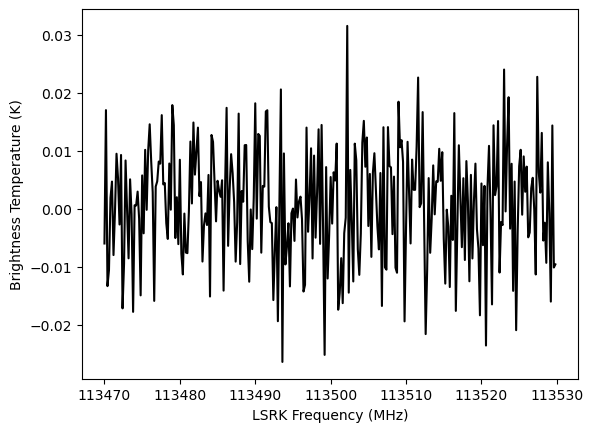

In [4]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(brightness_data)
observation._brightness_scale = observation.noise
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood for a given set of model parameters.

Transition 113144.19 is constraining upper state 3 from lower state 1
Transition 113191.325 is constraining upper state 2 from lower state 1
Transition 113490.985 is constraining upper state 1 from lower state 1
Transition 113508.934 is constraining upper state 0 from lower state 1
Transition 113520.4215 is constraining upper state 4 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 3
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]

Tex:
[[15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]]

tau_peak

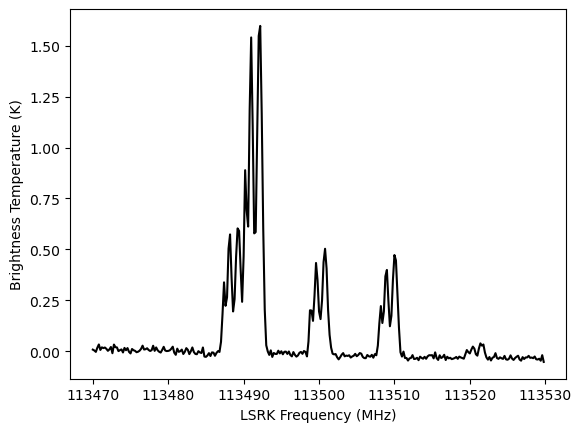

In [5]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [12.0, 1.0], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_sigma = 0.0, # assume no hyperfine anomalies
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N0": [12.5, 12.2, 11.8],
    "log10_Tkin": [1.2, 1.8, 1.9],
    "fwhm_nonthermal": [2.0, 1.5, 1.0],
    "velocity": [-3.0, 0.0, 2.0],
    "fwhm_L": 0.0,
    "baseline_observation_norm": [-2.0, -5.0, 8.0],
}
sim_brightness = model.model.observation.eval(sim_params, on_unused_input="ignore")
Tex = model.model.Tex.eval(sim_params, on_unused_input="ignore")
tau_peak = model.model.tau_peak.eval(sim_params, on_unused_input="ignore")
tau_total = model.model.tau_total.eval(sim_params, on_unused_input="ignore")
log10_N = model.model.log10_N.eval(sim_params, on_unused_input="ignore")
derived_params = {"log10_N": log10_N, "tau_total": tau_total}

print()
print("Tex:")
print(Tex)

print()
print("tau_peak:")
print(tau_peak)

print()
print("tau_total:")
print(tau_total)

print()
print("log10_N:")
print(log10_N)

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [6]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(sim_brightness)
observation._brightness_scale = observation.noise
data = {"observation": observation}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `CNModel`. Here we create a new model with the simulated data.

In [7]:
# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [12.0, 1.0], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_sigma = 0.0, # assume no hyperfine anomalies
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 3 from lower state 1
Transition 113191.325 is constraining upper state 2 from lower state 1
Transition 113490.985 is constraining upper state 1 from lower state 1
Transition 113508.934 is constraining upper state 0 from lower state 1
Transition 113520.4215 is constraining upper state 4 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 3
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]


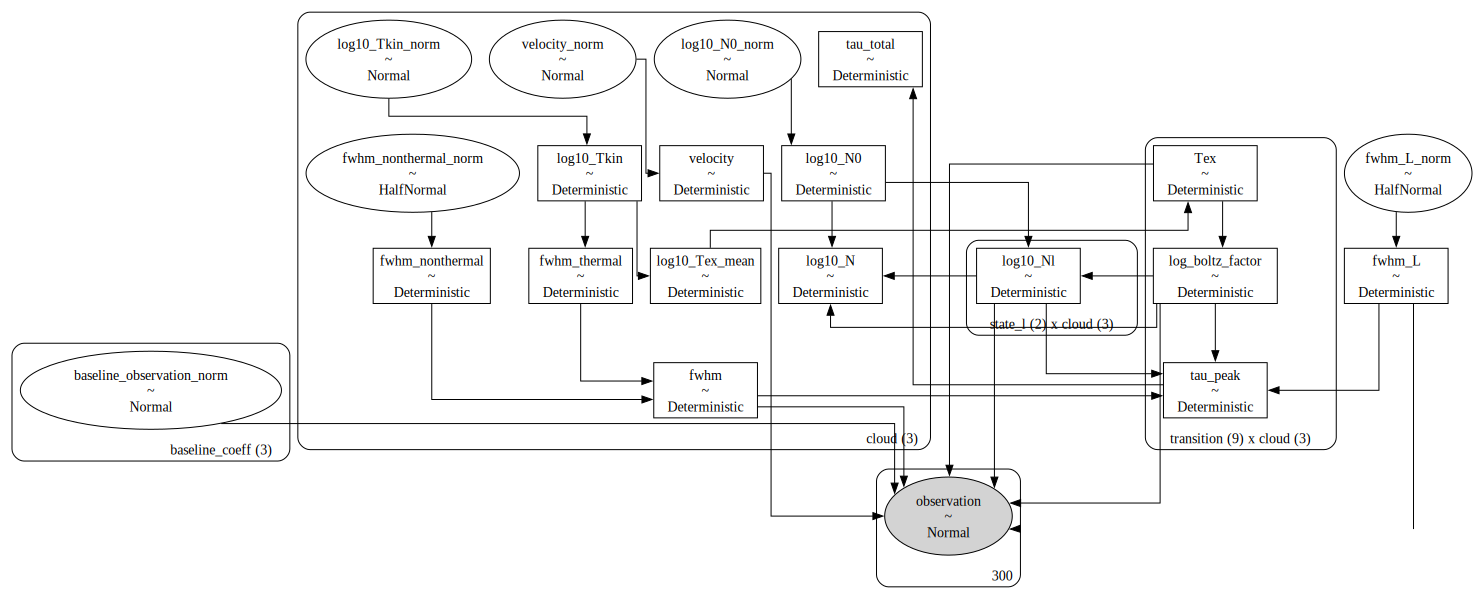

In [8]:
# Plot model graph
model.graph().render('cn_model', format='png')
model.graph()

In [9]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
            log10_N0_norm ~ Normal(0, 1)
          log10_Tkin_norm ~ Normal(0, 1)
            velocity_norm ~ Normal(0, 1)
     fwhm_nonthermal_norm ~ HalfNormal(0, 1)
              fwhm_L_norm ~ HalfNormal(0, 1)
                 log10_N0 ~ Deterministic(f(log10_N0_norm))
               log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
           log10_Tex_mean ~ Deterministic(f(log10_Tkin_norm))
                      Tex ~ Deterministic(f(log10_Tkin_norm))
         log_boltz_factor ~ Deterministic(f(log10_Tkin_norm))
                 log10_Nl ~ Deterministic(f(log10_N0_norm, log10_Tkin_norm))
                  log10_N ~ Deterministic(f(log10_N0_norm, log10_Tkin_norm))
                 velocity ~ Deterministic(f(velocity_norm))
             fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
          fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
                     fwhm ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
  

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_observation_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tkin_norm, observation, velocity_norm]


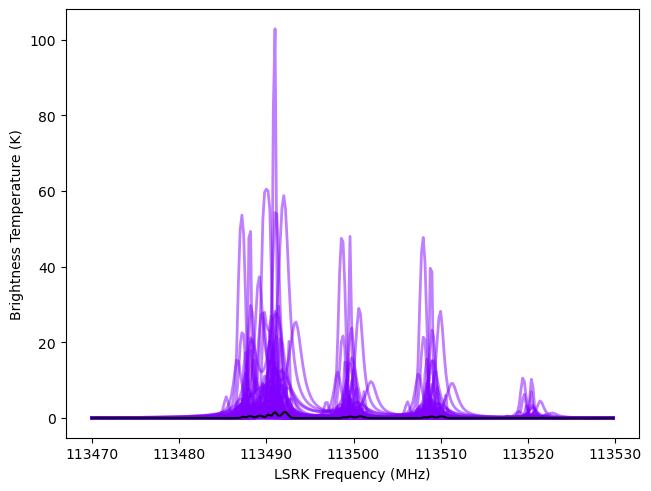

In [10]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [11]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 29,402


Output()

Runtime: 0.75 minutes


In [12]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N0[0],11.806,0.004,11.799,11.814,0.000,0.000,911.0,912.0,NaN
log10_N0[1],12.181,0.002,12.177,12.185,0.000,0.000,921.0,874.0,NaN
log10_N0[2],12.341,0.001,12.339,12.344,0.000,0.000,891.0,975.0,NaN
log10_Tkin[0],1.839,0.043,1.764,1.919,0.001,0.001,1007.0,908.0,NaN
log10_Tkin[1],1.973,0.028,1.920,2.024,0.001,0.001,804.0,850.0,NaN
log10_Tkin[2],1.922,0.019,1.884,1.956,0.001,0.000,1089.0,918.0,NaN
log10_Tex_mean[0],1.839,0.043,1.764,1.919,0.001,0.001,1007.0,908.0,NaN
log10_Tex_mean[1],1.973,0.028,1.920,2.024,0.001,0.001,804.0,850.0,NaN
log10_Tex_mean[2],1.922,0.019,1.884,1.956,0.001,0.000,1089.0,918.0,NaN
log10_N[0],12.559,0.005,12.549,12.567,0.000,0.000,1102.0,847.0,NaN


Sampling: [observation]


Output()

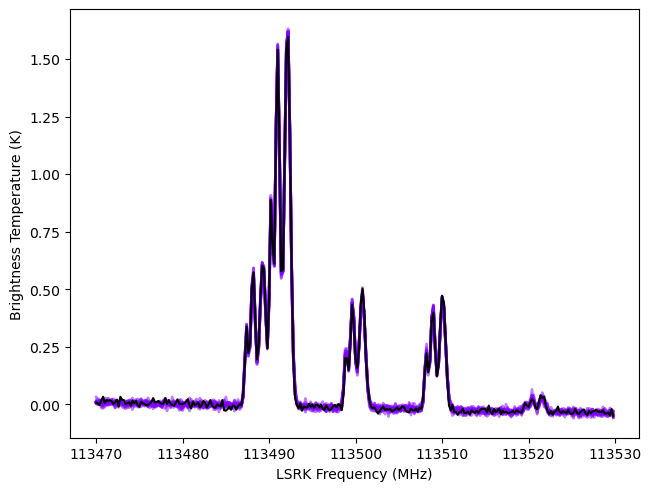

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 29,402
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, log10_N0_norm, log10_Tkin_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

In [ ]:
model.solve(kl_div_threshold=0.1)

In [ ]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [ ]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

In [ ]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition and state dependent parameters for clarity) along with the model hyper-parameters.

In [ ]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.savefig("cn_model_posterior_0.png")

In [ ]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [ ]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.savefig("cn_model_posterior_2.png")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [ ]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

In [ ]:
print(sim_params)
print(derived_params)